In [5]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [34]:
def load_data_from_sqlite(db_path):
    """Load data from SQLite database."""
    conn = sqlite3.connect(db_path)
    temp_change_diff = pd.read_sql_query("SELECT * FROM Temp_Change_Diff", conn)
    carbon_stocks_diff = pd.read_sql_query("SELECT * FROM Carbon_Stocks_Diff", conn)
    conn.close()
    return temp_change_diff, carbon_stocks_diff

In [35]:
def merge_data(temp_change_diff, carbon_stocks_diff):
    """Merge temperature change and carbon stocks data."""
    if 'Country' not in temp_change_diff.columns or 'Country' not in carbon_stocks_diff.columns:
        raise KeyError("'Country' column is missing from one of the DataFrames.")
    
    merged_df = pd.merge(temp_change_diff, carbon_stocks_diff, on='Country', suffixes=('_temp', '_carbon'))
    return merged_df

In [36]:
def calculate_global_correlations(merged_df):
    """Calculate global correlations."""
    global_temp_changes = merged_df.filter(like='_temp').mean()
    global_carbon_changes = merged_df.filter(like='_carbon').mean()

    global_correlations = pd.Series({
        f'F{year}': merged_df[f'F{year}_temp'].corr(merged_df[f'F{year}_carbon'])
        for year in range(1993, 2021)
    })
    return global_temp_changes, global_carbon_changes, global_correlations

In [37]:
def calculate_country_correlations(merged_df):
    """Calculate correlations for each country."""
    correlations = {}
    for country in merged_df['Country'].unique():
        country_data = merged_df[merged_df['Country'] == country]
        correlation = country_data.filter(like='_temp').corrwith(country_data.filter(like='_carbon'), axis=1).mean()
        correlations[country] = correlation
    correlations_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation']).reset_index().rename(columns={'index': 'Country'})
    return correlations_df

In [48]:
def visualize_results(global_temp_changes, global_carbon_changes, global_correlations, country_correlations):
    """Visualize the results."""

    # Time series plot of global changes
    plt.figure(figsize=(14, 7))
    plt.plot(range(1993, 2021), global_temp_changes, label='Global Temperature Changes', marker='o')
    plt.plot(range(1993, 2021), global_carbon_changes, label='Global Carbon Stock Changes', marker='o', color='green')
    plt.title('Global Year-over-Year Temperature and Carbon Stock Changes')
    plt.xlabel('Year')
    plt.ylabel('Change')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot global correlations over the years
    plt.figure(figsize=(10, 6))
    plt.plot(global_correlations.index, global_correlations.values, marker='o')
    plt.title('Global Correlation Between Temperature and Carbon Stock Changes Over Years')
    plt.xlabel('Year')
    plt.ylabel('Correlation Coefficient')
    
    # Reduce number of x-ticks for clarity
    plt.xticks(ticks=[i for i in range(0, len(global_correlations.index), 3)], 
               labels=[global_correlations.index[i] for i in range(0, len(global_correlations.index), 3)])
    
    plt.grid(True)
    plt.show()


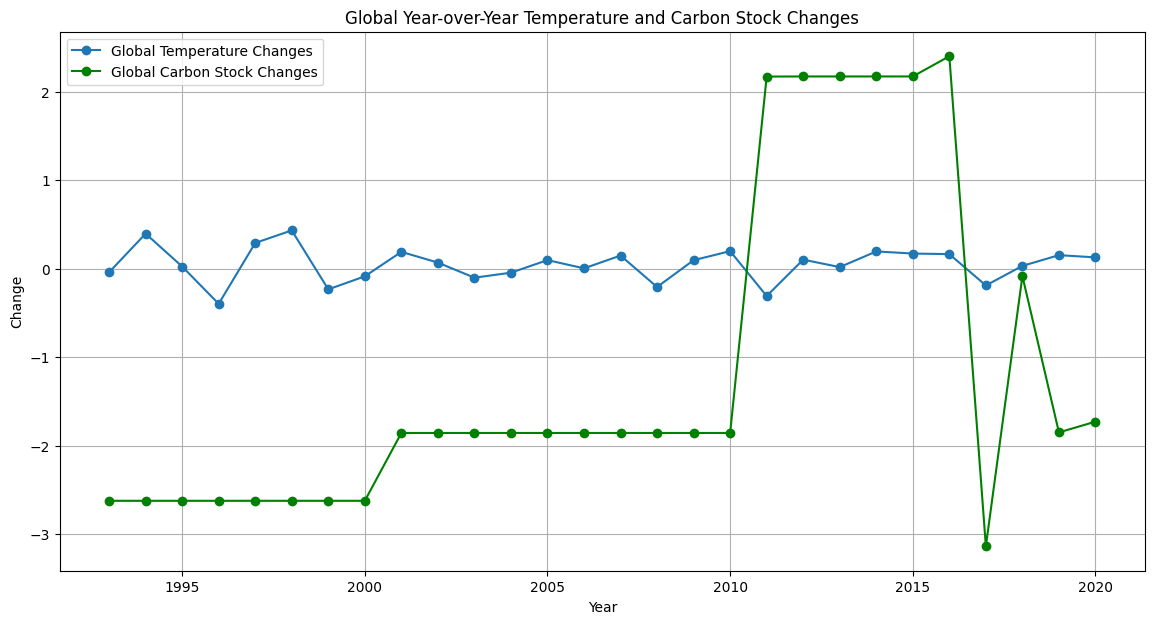

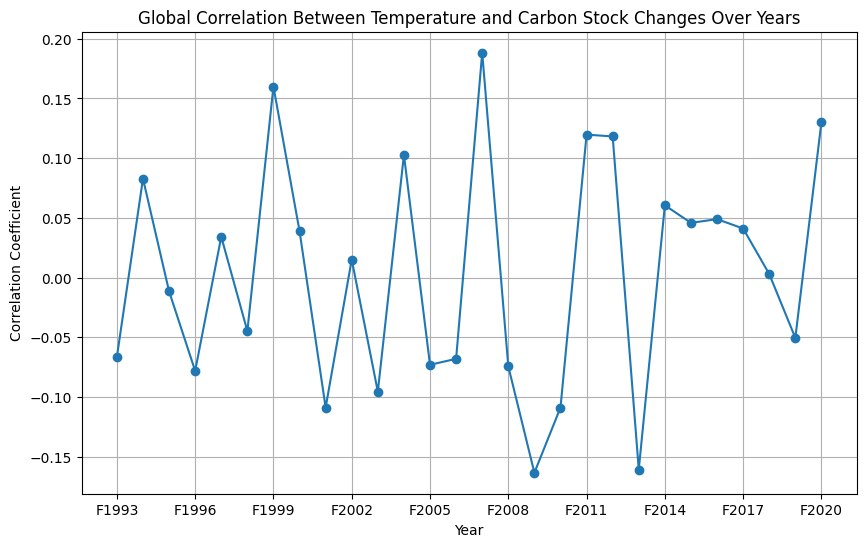

In [50]:
db_path = os.path.join('../data','climate_data.db')
temp_change_diff, carbon_stocks_diff = load_data_from_sqlite(db_path)
merged_df = merge_data(temp_change_diff, carbon_stocks_diff)
global_temp_changes, global_carbon_changes, global_correlations = calculate_global_correlations(merged_df)
country_correlations = calculate_country_correlations(merged_df)
visualize_results(global_temp_changes, global_carbon_changes, global_correlations, country_correlations)
